In [62]:
import torch, time, copy
import torch.nn as nn
import torch.optim as optim
from torch.quantization import prepare, convert
from src.utils import *
from src.override_resnet import *

# All default activation observer is HistogramObserver
cases_activation = [
    torch.quantization.HistogramObserver.with_args(reduce_range=True),
    torch.quantization.HistogramObserver.with_args(reduce_range=False),
]
# we can use 5 different type of weight observer
cases_weight = [
    # torch.quantization.HistogramObserver.with_args(dtype=torch.qint8),
    # torch.quantization.MinMaxObserver.with_args(dtype=torch.qint8),
    # torch.quantization.MovingAverageMinMaxObserver.with_args(dtype=torch.qint8),
    torch.quantization.PerChannelMinMaxObserver.with_args(dtype=torch.qint8),
    # torch.quantization.MovingAveragePerChannelMinMaxObserver.with_args(dtype=torch.qint8),
]


def fuse_ALL(model) -> nn.Module:
    SingleTimeFlag = False
    for m in model.modules():
        if m.__class__.__name__ == ResNet_quan.__name__:
            if SingleTimeFlag == True:
                raise ValueError("ResNet_quan is already fused")
            SingleTimeFlag = True
            torch.quantization.fuse_modules(
                m,
                ["conv1", "bn1", "relu"],
                inplace=True,
            )

        if type(m) == BottleNeck_quan:

            torch.quantization.fuse_modules(
                m,
                [
                    ["conv1", "bn1", "relu1"],
                    ["conv2", "bn2", "relu2"],
                    ["conv3", "bn3"],
                ],
                inplace=True,
            )
            if m.downsample is not None:
                torch.quantization.fuse_modules(
                    m.downsample,
                    ["0", "1"],
                    inplace=True,
                )
    return model


# for case_activation in cases_activation:
#     for case_weight in cases_weight:
# prepare the model
# for i in [120, 121, 122, 123, 124, 125, 126, 127, 128]:

model = resnet50_quan(weights=pretrained_weights_mapping[50])
model.to("cpu")
model.eval()

# set fuse ############################################################
model = fuse_ALL(model)

model.qconfig = torch.quantization.QConfig(
    activation=torch.quantization.HistogramObserver.with_args(
        quant_min=0, quant_max=127, upsample_rate=128
    ),
    weight=torch.quantization.PerChannelMinMaxObserver.with_args(dtype=torch.qint8),
)
prepare(model, inplace=True)

# calibrate the model ############################################################
criterion = nn.CrossEntropyLoss()
train_loader, _ = GetDataset(
    dataset_name="ImageNet",
    device="cuda",
    root="data",
    batch_size=256,
    num_workers=8,
)
_, _ = SingleEpochEval(model, train_loader, criterion, "cuda", 50)


  1%|          | 49/5005 [00:25<42:20,  1.95it/s] 


In [63]:
model.modules

<bound method Module.modules of ResNet_quan(
  (conv1): ConvReLU2d(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(inplace=True)
    (activation_post_process): HistogramObserver(min_val=0.0, max_val=57.47951889038086)
  )
  (bn1): Identity()
  (relu): Identity()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BottleNeck_quan(
      (conv1): ConvReLU2d(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (activation_post_process): HistogramObserver(min_val=0.0, max_val=23.185916900634766)
      )
      (bn1): Identity()
      (conv2): ConvReLU2d(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (activation_post_process): HistogramObserver(min_val=0.0, max_val=25.770811080932617)
      )
      (bn2): Identity()
      (conv3): Conv2d(
        64, 256, kernel_size=(1, 1), stride=(1,

In [ ]:
import matplotlib.pyplot as plt

torch.Size([2048])
2048


(array([   0.,    0.,    0.,    0.,    0., 2048.,    0.,    0.,    0.,
           0.]),
 array([-0.5       , -0.40000001, -0.30000001, -0.2       , -0.1       ,
         0.        ,  0.1       ,  0.2       ,  0.30000001,  0.40000001,
         0.5       ]),
 <BarContainer object of 10 artists>)

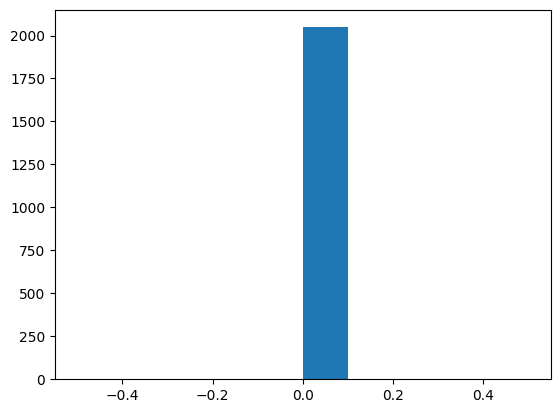

In [68]:
histogram = getattr(model.layer4.qconfig.activation.p(), "histogram")
print(histogram.shape)
#  = model.layer1[0].conv1.
print(len(histogram))

plt.hist(histogram)

In [ ]:

# convert the model ############################################################
model.to("cpu")
convert(model, inplace=True)

# evaluate the model ############################################################

_batch_size = 32
_, test_loader = GetDataset(
    dataset_name="ImageNet",
    device="cpu",
    root="data",
    batch_size=_batch_size,
    num_workers=8,
)

eval_loss, eval_acc = SingleEpochEval(
    model=model,
    testloader=test_loader,
    criterion=criterion,
    device="cpu",
    limit=10,
)
model_size = get_size_of_model(model)
inference_time = run_benchmark(model, test_loader, "cpu", 10)
print("------------------------------------------------------------")
# print(f"case_activation: {case_activation}")
# print(f"case_upsample_rate: {i}")
print(f"Model Size: {model_size:.2f}MB")
print(f"Inference Time: {inference_time:.2f}ms")
print(f"Eval Loss: {eval_loss:.4f}")
print(f"Eval Acc: {eval_acc:.3f}%")
print("\n")

print("Done!")

